### **Imports**

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

sns.set_theme(palette='bright')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [35]:
df = pd.read_csv('datasets/clean_bus_avg_ridership.csv')
df.head()

,route_id,route_name,month_beginning,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total
0,1,Indiana/Hyde Park,2001-01-01,6982.6,0.0,0.0,153617
1,2,Hyde Park Express,2001-01-01,1000.0,0.0,0.0,22001
2,3,King Drive,2001-01-01,21406.5,13210.7,8725.3,567413
3,4,Cottage Grove,2001-01-01,22432.2,17994.0,10662.2,618796
4,6,Jackson Park Express,2001-01-01,18443.0,13088.2,7165.6,493926


In [36]:
df.set_index('month_beginning', inplace=True)
df.index=pd.DatetimeIndex(df.index)
df.head()

,route_id,route_name,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total
month_beginning,,,,,,
2001-01-01,1,Indiana/Hyde Park,6982.6,0.0,0.0,153617
2001-01-01,2,Hyde Park Express,1000.0,0.0,0.0,22001
2001-01-01,3,King Drive,21406.5,13210.7,8725.3,567413
2001-01-01,4,Cottage Grove,22432.2,17994.0,10662.2,618796
2001-01-01,6,Jackson Park Express,18443.0,13088.2,7165.6,493926


In [37]:
df=df[['month_total', 'avg_weekday_rides', 'avg_saturday_rides', 'avg_sunday-holiday_rides']]

In [38]:
df=df[df.index < '2020-03-01']

In [39]:
# Code modified from code written by Matthew Garton
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    plt.figure(figsize=(18,9))

    for col in cols:

        plt.plot(df[col])
        
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

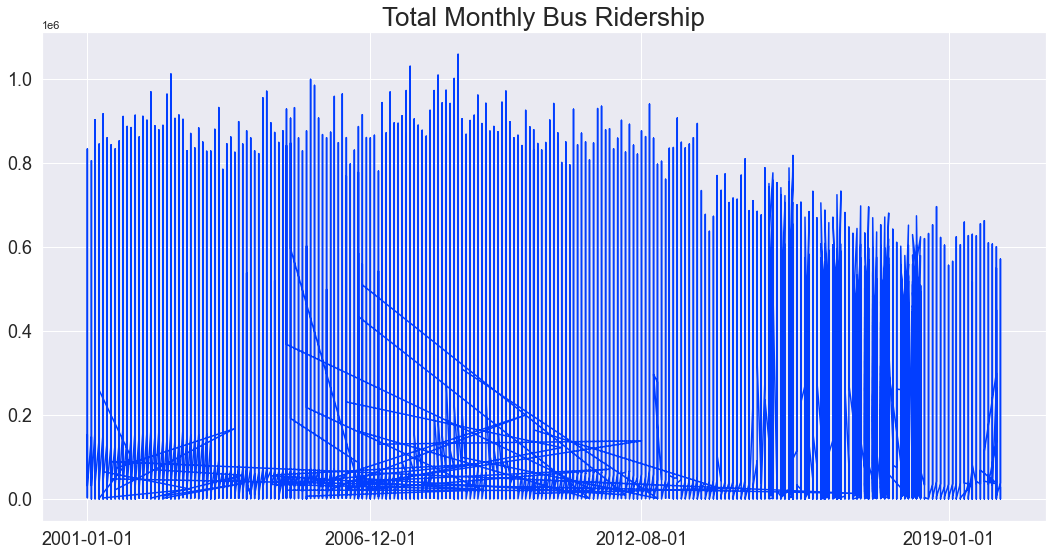

In [40]:
# Generate a time plot of our data.
plot_series(df, ['month_total'], 
            title = 'Total Monthly Bus Ridership', steps=10000)

In [41]:
df = df.resample('MS', closed = 'left').mean()

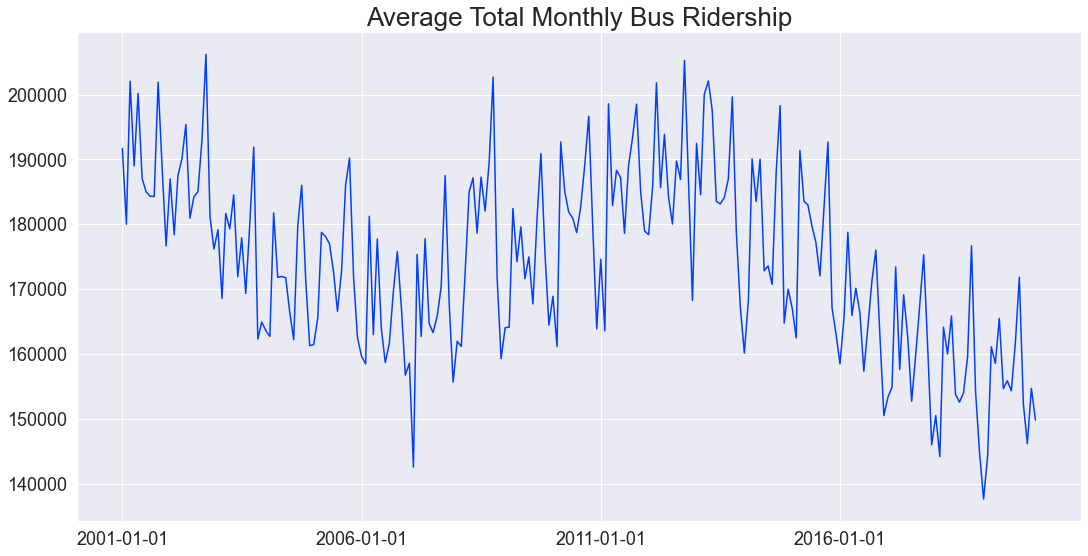

In [42]:
# Generate a time plot of our data.
plot_series(df, ['month_total'], 
            title = 'Average Total Monthly Bus Ridership', steps=60)

In [43]:
df.to_csv('time_series_bus_resampled.csv')

In [15]:
df['first_diff_total']=df['month_total'].diff(1)

In [16]:
df['second_diff_total']=df['month_total'].diff(1).diff(1)

In [17]:
# Code written by Joseph Nelson 
# Improved by Hovanes Gasparian
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [18]:
print(f"Stationarity of month total:\n{interpret_dftest(adfuller(df['month_total']))}")
print()
print(f"Stationarity of first-differenced month total:\n{interpret_dftest(adfuller(df['first_diff_total'].dropna()))}")
print()
print(f"Stationarity of second-differenced month total:\n{interpret_dftest(adfuller(df['second_diff_total'].dropna()))}")

Stationarity of month total:
Test Statistic    -1.928662
p-value            0.318700
Lag Used          14.000000
dtype: float64

Stationarity of first-differenced month total:
Test Statistic    -3.558628
p-value            0.006603
Lag Used          15.000000
dtype: float64

Stationarity of second-differenced month total:
Test Statistic   -1.406747e+01
p-value           2.980938e-26
Lag Used          1.200000e+01
dtype: float64


In [19]:
df['first_diff_weekday']=df['avg_weekday_rides'].diff(1)
df['second_diff_weekday']=df['avg_weekday_rides'].diff(1).diff(1)

In [20]:
print(f"Stationarity of Weekday Avg:\n{interpret_dftest(adfuller(df['avg_weekday_rides']))}")
print()
print(f"Stationarity of first-differenced Weekday Avg:\n{interpret_dftest(adfuller(df['first_diff_weekday'].dropna()))}")
print()
print(f"Stationarity of second-differenced Weekday Avg:\n{interpret_dftest(adfuller(df['second_diff_weekday'].dropna()))}")

Stationarity of Weekday Avg:
Test Statistic    -1.422905
p-value            0.571247
Lag Used          15.000000
dtype: float64

Stationarity of first-differenced Weekday Avg:
Test Statistic    -4.605895
p-value            0.000126
Lag Used          14.000000
dtype: float64

Stationarity of second-differenced Weekday Avg:
Test Statistic   -6.291632e+00
p-value           3.587444e-08
Lag Used          1.500000e+01
dtype: float64


In [21]:
df['first_diff_saturday']=df['avg_saturday_rides'].diff(1)
df['second_diff_saturday']=df['avg_saturday_rides'].diff(1).diff(1)

In [22]:
print(f"Stationarity of Saturday Avg:\n{interpret_dftest(adfuller(df['avg_saturday_rides']))}")
print()
print(f"Stationarity of first-differenced Saturday Avg:\n{interpret_dftest(adfuller(df['first_diff_saturday'].dropna()))}")
print()
print(f"Stationarity of second-differenced Saturday Avg:\n{interpret_dftest(adfuller(df['second_diff_saturday'].dropna()))}")

Stationarity of Saturday Avg:
Test Statistic    -1.147461
p-value            0.695779
Lag Used          15.000000
dtype: float64

Stationarity of first-differenced Saturday Avg:
Test Statistic    -3.400591
p-value            0.010939
Lag Used          14.000000
dtype: float64

Stationarity of second-differenced Saturday Avg:
Test Statistic   -1.152047e+01
p-value           4.051681e-21
Lag Used          1.300000e+01
dtype: float64


In [23]:
df['first_diff_sunday_holiday']=df['avg_sunday-holiday_rides'].diff(1)
df['second_diff_sunday_holiday']=df['avg_sunday-holiday_rides'].diff(1).diff(1)

In [24]:
print(f"Stationarity of Sunday & Holiday Avg:\n{interpret_dftest(adfuller(df['avg_sunday-holiday_rides']))}")
print()
print(f"Stationarity of first-differenced Sunday & Holiday Avg:\n{interpret_dftest(adfuller(df['first_diff_sunday_holiday'].dropna()))}")
print()
print(f"Stationarity of second-differenced Sunday & Holiday Avg:\n{interpret_dftest(adfuller(df['second_diff_sunday_holiday'].dropna()))}")

Stationarity of Sunday & Holiday Avg:
Test Statistic    -1.669811
p-value            0.446730
Lag Used          14.000000
dtype: float64

Stationarity of first-differenced Sunday & Holiday Avg:
Test Statistic    -3.726026
p-value            0.003762
Lag Used          13.000000
dtype: float64

Stationarity of second-differenced Sunday & Holiday Avg:
Test Statistic   -1.046742e+01
p-value           1.310682e-18
Lag Used          1.400000e+01
dtype: float64


In [25]:
df_var = df[['first_diff_total', 'first_diff_weekday', 'first_diff_saturday', 'first_diff_sunday_holiday']].copy()
df_var.dropna(inplace = True)

In [26]:
train, test = train_test_split(df_var, test_size = 0.25, shuffle = False)

In [27]:
model_var = VAR(train)

In [28]:
var_model = model_var.fit(maxlags=10,ic='aic')

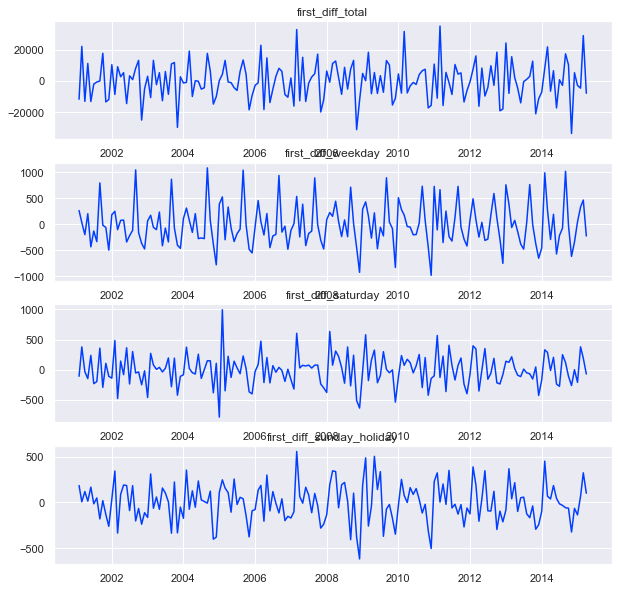

In [29]:
var_model.plot();

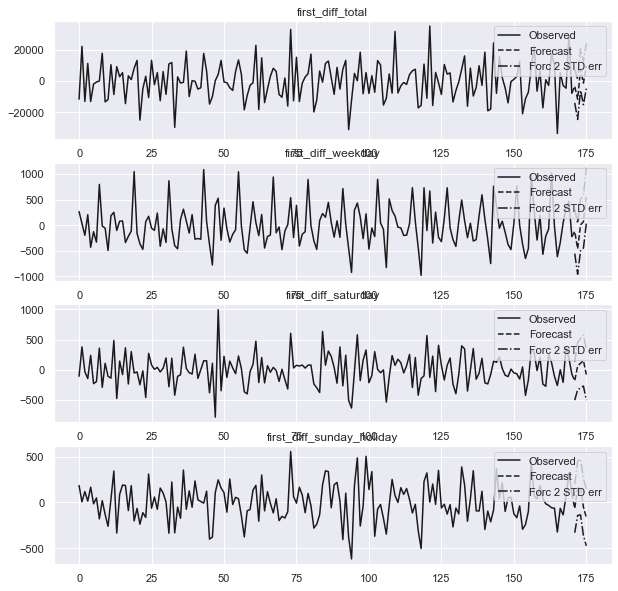

In [30]:
var_model.plot_forecast(5);

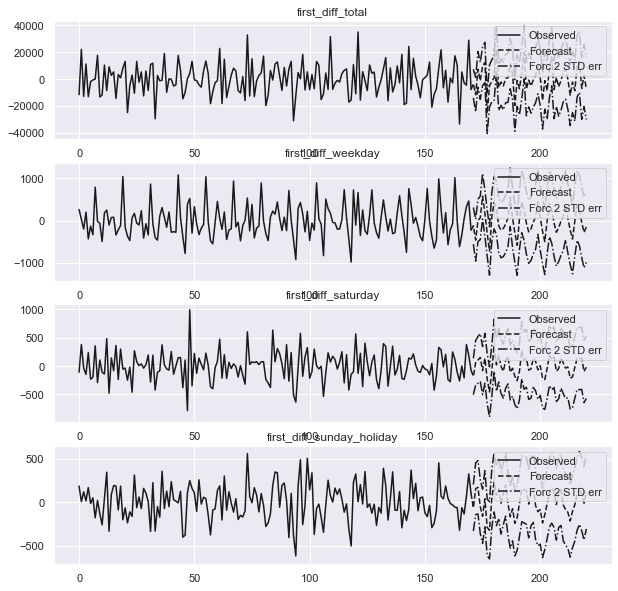

In [31]:
var_model.plot_forecast(50);

In [32]:
forecast = var_model.forecast(train.values, len(test))

In [33]:
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the first_diff_total data is: 54898731.7334
The test MSE on the first_diff_weekday data is: 56260.0223
The test MSE on the first_diff_saturday data is: 35219.9542
The test MSE on the first_diff_sunday_holiday data is: 20590.7579
